# Sign Language Recognition Notebook
## Introduction

This notebook introduce sign language recognition. Original code can be found in the diverse folders of this repository.

The main purpose of this project is to train AI models for sign language recognition. SVM models and classic neural network has been tested and can be found below. Some application of sign language recognition have also been implemented you can find them in "Application" folder.

### Environment
#### Installations

In [3]:
%pip install wheel setuptools pip --upgrade

  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
Using cached setuptools-69.2.0-py3-none-any.whl (821 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:
      Successfully uninstalled setuptools-65.5.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install lsfb_dataset
%pip install numpy
%pip install pandas
%pip install mediapipe
%pip install opencv-python
%pip install joblib
%pip install scikit-learn
%pip install torch
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tkvideoplayer-2.8-py3-none-any.whl.metadata (3.2 kB)
  Using cached av-9.2.0.tar.gz (2.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [74 lines of output]
      Compiling av\buffer.pyx because it changed.
      [1/1] Cythonizing av\buffer.pyx
      Compiling av\bytesource.pyx because it changed.
      [1/1] Cythonizing av\bytesource.pyx
      Compiling av\descriptor.pyx because it changed.
      [1/1] Cythonizing av\descriptor.pyx
      Compiling av\dictionary.pyx because it changed.
      [1/1] Cythonizing av\dictionary.pyx
      Compiling av\enum.pyx because it changed.
      [1/1] Cythonizing av\enum.pyx
      Compiling av\error.pyx because it changed.
      [1/1] Cythonizing av\error.pyx
      Compiling av\format.pyx because it changed.
      [1/1] Cythonizing av\format.pyx
      Compiling av\frame.pyx because it changed.
      [1/1] Cythonizing av\frame.pyx
      Compiling av\logging.pyx because it changed.
      [1/1] Cythonizing av\logging.pyx
      performance hint: av\logging.pyx:

In [5]:
%pip install pip==21.3.1


  Using cached pip-21.3.1-py3-none-any.whl.metadata (4.2 kB)
Using cached pip-21.3.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0



[notice] A new release of pip is available: 21.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install tkvideoplayer

  Using cached tkvideoplayer-2.8-py3-none-any.whl (6.2 kB)
  Using cached av-9.2.0.tar.gz (2.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Using cached tkvideoplayer-2.3-py3-none-any.whl (5.5 kB)
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'c:\Users\della\AppData\Local\Programs\Python\Python311\python.exe' 'c:\Users\della\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\della\AppData\Local\Temp\tmpa1a7ghep'
       cwd: C:\Users\della\AppData\Local\Temp\pip-install-k548n8op\av_dba2b6b642854a619ddea53e84ef8b09
  Complete output (74 lines):
  Compiling av\buffer.pyx because it changed.
  [1/1] Cythonizing av\buffer.pyx
  Compiling av\bytesource.pyx because it changed.
  [1/1] Cythonizing av\bytesource.pyx
  Compiling av\descriptor.pyx because it changed.
  [1/1] Cythonizing av\descriptor.pyx
  Compiling av\dictionary.pyx because it changed.
  [1/1] Cythonizing av\dictionary.pyx
  Compiling av\enum.pyx because it changed.
  [1/1] Cythonizing av\enum.pyx
  Compiling av\error.pyx because it changed.
  [1/1] Cythonizing av\error.pyx
  Compiling av\format.pyx because it change

#### Importations

In [1]:
import pandas as pd
import os
from lsfb_dataset import Downloader
import cv2
from cv2 import VideoCapture
import mediapipe as mp
import joblib

c:\Users\della\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Manipulation
### Download dataset

Dataset is based on the LSFB Corpus. This corpus is the result of the tremendous work achieved by the members of the LSFB lab from the university of Namur. LSFB Dataset (lsfb_dataset) is a companion library for the French Belgian Sign Language (LSFB) dataset released by this university. The library provides a set of tools helping to download, manipulate and visualize the data. <br>

> **See More** : For a more in-depth tour of lsfb-dataset, see [lsfb-dataset documentation](https://lsfb-team.github.io/lsfb-dataset/).

**Please be aware that downloading data can take a while.** We don't recommend you to change nb_signers as the rest of the code is only designed for the signs selected according to this download parameters.

In [2]:
nb_signers = 8

downloader = Downloader(
    dataset='isol',
    destination="Database/Dataset",
    splits=['train','test'],
    signers=list(range(nb_signers)),
    include_cleaned_poses=False,
    include_raw_poses=False,
    include_videos=True,
    landmarks=['pose', 'left_hand', 'right_hand'],
    skip_existing_files=True,
)
downloader.download()

Videos for 19926 instances: 100%|██████████| 19926/19926 [00:00<00:00, 50509.75files/s] 


### Select data
The first selection of a video is based on the following criteria : 
 - it has more than 10 frames and less than 50 frames
 - it represents one of the 5 most represented signs of the global databaset
 - the word it represents is represented more than 50 times

> **Warning** : if necessary, please change the following directories to your dataset folder

In [3]:
videos_directory = "Database/Dataset/videos/" 
df_instances = pd.read_csv('Database/Dataset/instances.csv', engine='python')
df_index = pd.read_csv('Database/sign_to_index.csv')

In [4]:
signs = [df_index.loc[i, "sign"] for i in range(5)]
points = [0,4,8,12,16,20]
print(signs)

['AUSSI', 'LS', 'OUI', 'AVOIR', 'SOURD']


How many signing videos for each word ?

In [5]:
def Paths_Videos_Signing(word):
    """return a list of paths of videos signing the parameter word

    Args:
        word (string): word to search in dataset
    Returns:
        list: list of string representing video paths
    """
    videos = []
    df_instances_word = df_instances.loc[df_instances['sign'] == word]
    for title in df_instances_word['id']:
        path = videos_directory + title + ".mp4"
        if os.path.exists(path):
            videos.append(path)
    return videos

In [6]:
for sign in signs:
    print(f"{sign} : {len(Paths_Videos_Signing(sign))}")

AUSSI : 371
LS : 342
OUI : 314
AVOIR : 280
SOURD : 130


Selection based on numeric criteria : number of frames and number of signing videos

In [7]:
minimum_videos = 200 # Nombre minimal de vidéos pour pouvoir garder un mot en base de données
len_min = 10
len_max = 50

In [8]:
def Paths_Selected_Videos(word):
    videos = Paths_Videos_Signing(word)
    selected_videos = []
    for video in videos:
        cap = cv2.VideoCapture(video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if length>len_min and length<len_max:
            selected_videos.append(video)
    return selected_videos

In [9]:
for sign in signs:
    print(f"Number of videos signing '{sign}' : {len(Paths_Videos_Signing(sign))} before, {len(Paths_Selected_Videos(sign))} after")

Number of videos signing 'AUSSI' : 371 before, 297 after
Number of videos signing 'LS' : 342 before, 297 after
Number of videos signing 'OUI' : 314 before, 265 after
Number of videos signing 'AVOIR' : 280 before, 223 after
Number of videos signing 'SOURD' : 130 before, 109 after


In [10]:
for sign in signs:
    if len(Paths_Selected_Videos(sign))<minimum_videos:
        signs.remove(sign)

print("For the rest of the project, we will be working on the following words :")
print(signs)
joblib.dump(signs, "DataManipulation/Data/Signs.pkl")

For the rest of the project, we will be working on the following words :
['AUSSI', 'LS', 'OUI', 'AVOIR']


['DataManipulation/Data/Signs.pkl']

### Data formatting
#### Vectorization

To convert videos in vectors for training, we use MediaPipe Hand Landmark Detection model with relative coordinates. In order to lower computation time and storage space, we only use 6 of the 20 points available in MediaPipe detection. 
<center><img src="./images/HandLandmarks.png" width="200" /></center>


In [11]:
# Téléchargement du modèle détecteur de mains
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.8)

In [12]:
def Vectorize(video_path, points):
    """return a matrix containing the coordinates of points (according to MediaPipe) that have been extracted from the video saved in directory path

    Args:
        directory (string): path of the video that should be convert in matrix data
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        nparray: matrix corresponding to the following data,
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
    """
    capture = VideoCapture(video_path)

    vect = [ [] for i in range(len(points))]
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break 
        
        #BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# MediaPipe works with RGB format

        # Set flag
        image.flags.writeable = False

        #Detections
        results = hands.process(image)
        rang = 0
        for point in points:
            res = results.multi_hand_world_landmarks
            if res == None: # Without hand detection
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
            else :
                if len(res)>=2: # With a detection of both hands
                    hand = results.multi_hand_world_landmarks[0]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)
                    hand = results.multi_hand_world_landmarks[1]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)          
                
                elif len(res)==1: # With a one-hand detection
                    res2 = results.multi_handedness[0]
                    label = res2.classification[0].label
                    hand = results.multi_hand_world_landmarks[0]
                    if label == "Left":
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        
                    elif label == "Right" :
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                
            rang +=1
        
    return vect

Conversion to dataframe format

In [13]:
def Create_DataFrame(video, points):
    """Create a dataframe based on what Vectorise function returns

    Args:
        video (string): path of the video that will be convert in a dataframe
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>

    Returns:
        dataFrame: dataframe corresponding to the matrix extracted from the video given by Vectorise function
    """
    vect = Vectorize(video, points)
    col = ["Points"]
    
    for i in range(len(vect[0])//6):
        col += [f'xG{i}',f'yG{i}',f'zG{i}',f'xD{i}',f'yD{i}',f'zD{i}']
    
    df = pd.DataFrame(None, columns = col)
    for i in range(len(points)):
        df.loc[len(df.index)] = [f"P{4*i}"] + vect[i]

    return df

Example of the dataframe created from the first video signing "LS" in database

In [16]:
video = Paths_Selected_Videos("LS")[0]
Create_DataFrame(video, points)

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG15,xD15,yD15,zD15,xG16,yG16,zG16,xD16,yD16,zD16
0,P0,-0.035230,0.042146,0.073656,0.066154,0.008858,0.059337,-0.025272,0.046615,0.075060,...,0.075538,0.043564,0.014199,0.079540,0.029654,0.055051,0.074103,0.062954,0.018715,0.057508
1,P4,0.006634,-0.054196,0.005010,-0.001107,-0.074753,-0.000785,0.019382,-0.050444,0.009267,...,-0.000306,-0.025795,-0.061216,0.017933,0.062072,-0.047171,-0.012701,-0.015709,-0.005951,0.025426
2,P8,0.034817,0.017221,0.041634,-0.061179,-0.030260,0.020100,0.055951,0.004189,0.023389,...,-0.042504,-0.027040,-0.051357,-0.033080,-0.019221,-0.061134,-0.048849,-0.035414,-0.060699,-0.012632
3,P12,0.029182,0.012646,0.035624,-0.076076,0.001638,0.029415,0.047710,0.012097,0.028550,...,-0.071690,-0.048773,-0.010769,-0.022032,-0.043118,-0.027342,-0.067052,-0.057198,-0.011822,0.005704
4,P16,0.025709,0.027869,0.028479,-0.060427,0.019197,0.024898,0.044877,0.027482,0.027394,...,-0.057073,-0.057068,0.029403,-0.007605,-0.008420,0.039443,-0.038408,-0.059866,0.037741,0.020737
5,P20,0.033297,0.035249,0.004762,-0.041467,0.057452,0.017356,0.041275,0.039010,0.013481,...,-0.034258,-0.040132,0.061078,0.000094,-0.006039,0.052325,-0.017872,-0.038108,0.067305,0.020124


#### Generalisation

- concat info of every video
- save every video under a unique csv relative to the signed word

In [14]:
def Concatenate_DataFrame(sign, points):
    """concatenate data in a unique dataframe 

    Args:
        sign (list of stirng): list of sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        pd.Dataframe: 
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video 1
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
        
        ...
        
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video N
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20]
    """
    videos = Paths_Selected_Videos(sign)
    df = pd.DataFrame(None)

    if len(videos)>=minimum_videos:
        for video in videos:
            df = pd.concat([df,Create_DataFrame(video, points)], ignore_index=True)
    return df

Example for the word "LS"

In [45]:
#Concatenate_DataFrame("LS", points)

In [15]:
def SaveInCSV(sign, points):
    """save dataframe created by Concatenate_DataFrame in csv

    Args:
        sign (string): sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    """
    if not os.path.exists(f'Database/Positions/{sign}.csv'):
        df = Concatenate_DataFrame(sign, points)
        df.to_csv(f'Database/Positions/{sign}.csv', index=False)

In [16]:
for sign in signs:
    SaveInCSV(sign,points)

### Data processing

Concatenate every sign data before in order to have same length for every X vector

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

In [20]:
signs = joblib.load("DataManipulation/Data/Signs.pkl")
signs

['AUSSI', 'LS', 'OUI', 'AVOIR']

In [21]:
List_df_signs = [pd.read_csv(f"Database/Positions/{sign}.csv") for sign in signs]
df_All = pd.concat(List_df_signs)
df_All

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG47,xD47,yD47,zD47,xG48,yG48,zG48,xD48,yD48,zD48
0,P0,0.0,0.0,0.0,0.0,0.0,0.0,0.015559,0.083049,0.044787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P4,0.0,0.0,0.0,0.0,0.0,0.0,0.034177,-0.023254,-0.028474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,0.0,0.0,0.0,0.0,0.0,0.0,-0.004072,-0.096158,-0.025613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P12,0.0,0.0,0.0,0.0,0.0,0.0,0.027751,0.022401,-0.015144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,0.0,0.0,0.0,0.0,0.0,0.0,0.021707,0.047777,-0.010973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,P4,0.0,0.0,0.0,0.0,0.0,0.0,0.000873,0.024254,0.003159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1334,P8,0.0,0.0,0.0,0.0,0.0,0.0,0.022978,0.042134,0.039144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,P12,0.0,0.0,0.0,0.0,0.0,0.0,0.033054,0.056850,0.027615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,P16,0.0,0.0,0.0,0.0,0.0,0.0,0.030419,0.054961,0.019449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Convert to numpy to concatenate rows

In [22]:
All = np.array(df_All)
final_vector = []
for i in range (len(All)//len(points)):
    final_vector += [np.concatenate([All[point+i*6][1:] for point in range(6)])]

- Return to Dataframe

In [23]:
df_All = pd.DataFrame(final_vector)
df_All

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015559,0.083049,0.044787,0.006316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012938,0.082440,0.041306,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060475,0.006571,0.077605,0.012307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.049384,0.030766,0.071968,-0.016525,0.074820,0.068859,0.049453,0.028812,0.075394,-0.008487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.049849,0.021614,0.077442,-0.022396,0.072228,0.072210,0.046102,0.027305,0.079739,-0.012087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001044,0.041654,0.090977,-0.041178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,-0.063210,0.061234,0.047186,0.000000,0.000000,0.000000,0.043812,-0.036999,0.073891,-0.058167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,0.009083,0.077887,0.048610,-0.004348,0.083721,0.034025,0.009551,0.076776,0.058762,-0.008330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Find targets

In [24]:
df_correspondances = pd.read_csv('Database/sign_to_index.csv')
targets =[]
for num_sign in range(len(signs)):
    ind = 0
    nb_videos = List_df_signs[num_sign].shape[0]//len(points)
    while ind < df_correspondances.shape[0] and df_correspondances.loc[ind, "sign"]!=signs[num_sign]:
        ind+=1
    targets += [ind]*nb_videos
unique, counts = np.unique(targets, return_counts=True)
dict(zip(unique, counts))

{0: 297, 1: 297, 2: 265, 3: 223}

- Concatenate data (X and y)

In [25]:
X = np.array(df_All)
X_training, X_test, y_training, y_test = train_test_split(X, targets, test_size=0.20)

df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)

df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032816,0.067850,0.063856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029561,-0.005819,0.063199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.000000,0.000000,0.000000,0.028828,0.037451,0.071719,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,-0.012577,0.035698,0.088188,0.000000,0.000000,0.000000,0.023023,0.010435,0.078173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,-0.010275,0.050706,0.088326,0.000000,0.000000,0.000000,-0.006432,0.047825,0.077888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,1,0.000000,0.000000,0.000000,0.014638,0.055577,0.068910,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861,1,-0.030326,0.048212,0.077239,0.000000,0.000000,0.000000,-0.028779,0.047219,0.079026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,3,-0.015124,0.086089,0.025050,0.000000,0.000000,0.000000,-0.021990,0.083526,0.025738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001336,0.011859,0.046890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_training.to_csv(f'DataManipulation/Data/RawTraining.csv', index=False)
df_test.to_csv(f'DataManipulation/Data/RawTest.csv', index=False)

#### Data Preparation

In [27]:
df_training = pd.read_csv("DataManipulation/Data/RawTraining.csv")
df_test = pd.read_csv("DataManipulation/Data/RawTest.csv")

On ne garde que les vidéos dont 99% des valeurs enregistrées (pour sa durée) portent de l'information

In [28]:
def Keep_Indicatives(df_data):
    Data = np.array(df_data)
    ind_video = 0 
    for video in Data:
        number_of_zero = np.count_nonzero(video[1:] == 0)
        nbTotal = np.count_nonzero(video[1:] != np.nan)
        if number_of_zero>0.1*nbTotal:
            Data = np.delete(Data, ind_video, axis=0)
        else:
            ind_video +=1
    return Data

How many videos left ?

In [29]:
df_data = pd.read_csv(f"DataManipulation/Data/RawTraining.csv")
print(f"Number of videos before 2nd selection on training set : {df_training.shape[0]}")
new = Keep_Indicatives(df_training)
print(f"Number of videos after 2nd selection on training set : {len(new)}")
unique, counts = np.unique(new[:,0], return_counts=True)
dict(zip(unique, counts))

Number of videos before 2nd selection on training set : 865
Number of videos after 2nd selection on training set : 555


{0.0: 173, 1.0: 116, 2.0: 121, 3.0: 145}

In [30]:
df_training = pd.DataFrame(Keep_Indicatives(df_training))
df_test = pd.DataFrame(Keep_Indicatives(df_test))
df_training

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764
0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029561,-0.005819,0.063199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-0.012577,0.035698,0.088188,0.000000,0.000000,0.000000,0.023023,0.010435,0.078173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.002478,0.081479,0.058552,0.058675,0.026049,0.060926,0.007707,0.082217,0.057493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015446,0.051787,0.076967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006192,0.025990,0.068699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005717,0.064700,0.067209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,0.0,0.000000,0.000000,0.000000,0.029169,0.027398,0.077888,-0.036599,0.027040,0.083079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016985,-0.011807,0.090949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.070467,0.031793,0.055411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Transformer les NaN en 0

In [31]:
Data_training = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_training)
Data_test = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_test)

In [32]:
X_training = [Data_training[video][1:] for video in range(len(Data_training))]
y_training = [Data_training[video][0] for video in range(len(Data_training))]
X_test = [Data_test[video][1:] for video in range(len(Data_test))]
y_test = [Data_test[video][0] for video in range(len(Data_test))]

In [33]:
df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)
df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029561,-0.005819,0.063199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.012577,0.035698,0.088188,0.000000,0.000000,0.000000,0.023023,0.010435,0.078173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.002478,0.081479,0.058552,0.058675,0.026049,0.060926,0.007707,0.082217,0.057493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015446,0.051787,0.076967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006192,0.025990,0.068699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005717,0.064700,0.067209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.0,0.000000,0.000000,0.000000,0.029169,0.027398,0.077888,-0.036599,0.027040,0.083079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016985,-0.011807,0.090949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
553,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.070467,0.031793,0.055411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the rest of the Notebook, we will use Test.csv and Training.csv files as datasets.

In [34]:
df_training.to_csv(f'DataManipulation/Data/Training.csv', index=False)
df_test.to_csv(f'DataManipulation/Data/Test.csv', index=False)

## Models
### Support vector machines
#### Importation

In [35]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [36]:
data_training = pd.read_csv("DataManipulation/Data/Training.csv")
data_test = pd.read_csv("DataManipulation/Data/Test.csv")
data_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029561,-0.005819,0.063199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.012577,0.035698,0.088188,0.000000,0.000000,0.000000,0.023023,0.010435,0.078173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.002478,0.081479,0.058552,0.058675,0.026049,0.060926,0.007707,0.082217,0.057493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015446,0.051787,0.076967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006192,0.025990,0.068699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005717,0.064700,0.067209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.0,0.000000,0.000000,0.000000,0.029169,0.027398,0.077888,-0.036599,0.027040,0.083079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016985,-0.011807,0.090949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
553,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.070467,0.031793,0.055411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_training = data_training.iloc[ : , 1:]
y_training = data_training['Target']
X_test = data_test.iloc[ : , 1:]
y_test = data_test['Target']

X_training = X_training.values
y_training = y_training.values
X_test = X_test.values
y_test = y_test.values

#### Training

In [38]:
SVM_model = svm.SVC(probability=True)
SVM_model.fit(X_training, y_training)

SVC(probability=True)

In [39]:
import joblib
joblib.dump(SVM_model, "Application/Direct/SVM_model.pkl")

['Application/Direct/SVM_model.pkl']

#### Results

Accuracy

In [40]:
y_pred = SVM_model.predict(X_test)
train_acc = SVM_model.score(X_training, y_training)
print(f"Training accuracy: {train_acc:.04f}")
test_acc = np.sum(y_pred == y_test) / len(y_test)
print(f"Test accuracy: {test_acc:.4f}")

Training accuracy: 0.9423
Test accuracy: 0.7902


In [41]:
print(classification_report(y_training, SVM_model.predict(X_training)))
print(classification_report(y_test, SVM_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       173
         1.0       0.94      0.96      0.95       116
         2.0       0.96      0.91      0.94       121
         3.0       0.92      0.92      0.92       145

    accuracy                           0.94       555
   macro avg       0.94      0.94      0.94       555
weighted avg       0.94      0.94      0.94       555

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88        41
         1.0       0.81      0.78      0.79        32
         2.0       0.84      0.64      0.73        42
         3.0       0.69      0.79      0.73        28

    accuracy                           0.79       143
   macro avg       0.79      0.79      0.78       143
weighted avg       0.80      0.79      0.79       143



Cross-validation

In [42]:
cv_acc_training = cross_val_score(SVM_model, X_training, y_training, cv=5, scoring="accuracy")
cv_acc_test = cross_val_score(SVM_model, X_test, y_test, cv=5, scoring="accuracy")
print(f"Cross-validation training accuracy: {cv_acc_training}")
print(f"Cross-validation test accuracy: {cv_acc_test}")

Cross-validation training accuracy: [0.79279279 0.78378378 0.84684685 0.73873874 0.72972973]
Cross-validation test accuracy: [0.72413793 0.75862069 0.5862069  0.60714286 0.75      ]


Confusion matrix

Confusion matrix, without normalization
[[39  0  1  1]
 [ 1 25  4  2]
 [ 2  6 27  7]
 [ 6  0  0 22]]
Normalized confusion matrix
[[0.95121951 0.         0.02439024 0.02439024]
 [0.03125    0.78125    0.125      0.0625    ]
 [0.04761905 0.14285714 0.64285714 0.16666667]
 [0.21428571 0.         0.         0.78571429]]


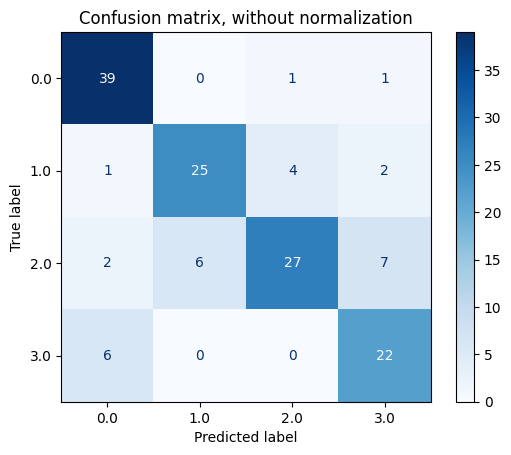

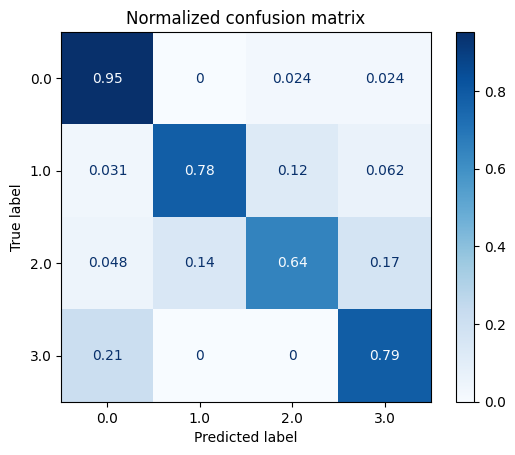

In [43]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_model,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Neural Network
#### Preparation
Importations

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [49]:
data_training = pd.read_csv("DataManipulation/Data/Training.csv")
data_test = pd.read_csv("DataManipulation/Data/Test.csv")

In [50]:
X_training = data_training.drop('Target', axis=1)
y_training = data_training["Target"]
X_test = data_test.drop('Target', axis=1)
y_test =data_test["Target"]
X_training

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029561,-0.005819,0.063199,0.040754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.012577,0.035698,0.088188,0.000000,0.000000,0.000000,0.023023,0.010435,0.078173,-0.021959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002478,0.081479,0.058552,0.058675,0.026049,0.060926,0.007707,0.082217,0.057493,0.053474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015446,0.051787,0.076967,0.029865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006192,0.025990,0.068699,0.002576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005717,0.064700,0.067209,0.053114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.000000,0.000000,0.000000,0.029169,0.027398,0.077888,-0.036599,0.027040,0.083079,0.033885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016985,-0.011807,0.090949,0.001027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.070467,0.031793,0.055411,-0.004160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Labels, i.e. fashion categories associated to images (one category per image)
sign_labels = {
    0: "AUSSI",
    1: "LS",
    2: "OUI",
    3: "AVOIR"
}

# Try to change the learning rate to 1e-2 ans check training results
learning_rate = 1
n_epochs = 30
batch_size = 10
inputs = 1764
outputs = 4

Environment

In [52]:
# PyTorch device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA GPU {torch.cuda.get_device_name(0)} found :)")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

No GPU found, using CPU instead


Tensor creation <br>
Be sure to use float32 format for PyTorch tensors

In [53]:
X_training = np.array(X_training)
y_training = np.array(y_training)
X_test = np.array(X_test)
Y_test = np.array(y_test)
X_np = X_training.astype(np.float32)
Y_np = y_training.astype(np.float32)  

In [54]:
X_training = torch.tensor(X_training, dtype=torch.float32).to(device)
y_training = torch.tensor(y_training, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [55]:
print(f"x_train: {X_training.shape}. y_train: {y_training.shape}")
print(f"x_test: {X_test.shape}. y_test: {y_test.shape}")
print(X_training)

x_train: torch.Size([555, 1764]). y_train: torch.Size([555])
x_test: torch.Size([143, 1764]). y_test: torch.Size([143])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0126,  0.0357,  0.0882,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0025,  0.0815,  0.0586,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0151,  0.0861,  0.0251,  ...,  0.0000,  0.0000,  0.0000]])


In [56]:
sign_train_dataloader = DataLoader(list(zip(X_training,y_training)), batch_size=batch_size)
sign_test_dataloader = DataLoader(list(zip(X_test,y_test)), batch_size=batch_size)

#### Model definition

In [57]:
class NeuralNetwork(nn.Module):
    """Neural network for fashion articles classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (1, 28, 28) into a vector of shape (28*28,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 784 inputs
            nn.Linear(in_features=1764, out_features=2048),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),

            # Output layer
            nn.Linear(in_features=64, out_features=4),
            nn.Softmax()
        )
    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [58]:
sign_model = NeuralNetwork().to(device)
print(sign_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=1764, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
    (7): Softmax(dim=None)
  )
)


In [59]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(sign_model.parameters(), lr=learning_rate)

In [60]:
def epoch_loop(dataloader, model, loss_fn, optimizer):
    """Training algorithm for one epoch"""

    total_loss = 0
    n_correct = 0

    for x_batch, y_batch in dataloader:
        # Load data and targets on device memory
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        # Backward pass: backprop and GD step
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            total_loss += loss.item()
            n_correct += (model(x_batch).argmax(dim=1) == y_batch).float().sum().item()

    return total_loss, n_correct

In [61]:
def train_sign(dataloader, model, loss_fn, optimizer):
    """Main training loop"""

    history = {"loss": [], "acc": []}
    n_samples = len(dataloader.dataset)
    n_batches = len(dataloader)

    print(f"Training started! {n_samples} samples. {n_batches} batches per epoch")

    for epoch in range(n_epochs):
        total_loss, n_correct = epoch_loop(dataloader, model, loss_fn, optimizer)

        # Compute epoch metrics
        epoch_loss = total_loss / n_batches
        epoch_acc = n_correct / n_samples

        print(
            f"Epoch [{(epoch + 1):3}/{n_epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

        # Record epoch metrics for later plotting
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

    print(f"Training complete! Total gradient descent steps: {n_epochs * n_batches}")

    return history

In [62]:
sign_history = train_sign(
    sign_train_dataloader,
    sign_model,
    loss_fn,
    optimizer,
)

Training started! 555 samples. 56 batches per epoch


c:\Users\della\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [  1/ 30]. Mean loss: 1.37984. Accuracy: 31.35%
Epoch [  2/ 30]. Mean loss: 1.37261. Accuracy: 31.17%
Epoch [  3/ 30]. Mean loss: 1.30952. Accuracy: 39.64%
Epoch [  4/ 30]. Mean loss: 1.20668. Accuracy: 55.68%
Epoch [  5/ 30]. Mean loss: 1.16501. Accuracy: 61.26%
Epoch [  6/ 30]. Mean loss: 1.14183. Accuracy: 63.78%
Epoch [  7/ 30]. Mean loss: 1.09394. Accuracy: 68.47%
Epoch [  8/ 30]. Mean loss: 1.14027. Accuracy: 62.70%
Epoch [  9/ 30]. Mean loss: 1.06553. Accuracy: 71.53%
Epoch [ 10/ 30]. Mean loss: 1.06628. Accuracy: 68.11%
Epoch [ 11/ 30]. Mean loss: 1.07948. Accuracy: 67.57%
Epoch [ 12/ 30]. Mean loss: 1.12630. Accuracy: 66.31%
Epoch [ 13/ 30]. Mean loss: 1.07009. Accuracy: 71.53%
Epoch [ 14/ 30]. Mean loss: 1.08373. Accuracy: 69.91%
Epoch [ 15/ 30]. Mean loss: 1.01695. Accuracy: 78.92%
Epoch [ 16/ 30]. Mean loss: 1.02393. Accuracy: 77.48%
Epoch [ 17/ 30]. Mean loss: 0.98923. Accuracy: 80.00%
Epoch [ 18/ 30]. Mean loss: 1.00070. Accuracy: 79.28%
Epoch [ 19/ 30]. Mean loss: 

#### Results
Accuracy and loss plots

In [63]:
def plot_loss_acc(history):
    """Plot training loss and accuracy. Takes a Keras-like History object as parameter"""

    loss_values = history["loss"]
    recorded_epochs = range(1, len(loss_values) + 1)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(recorded_epochs, loss_values, ".--", label="Training loss")
    ax1.set_ylabel("Loss")
    ax1.legend()

    acc_values = history["acc"]
    ax2.plot(recorded_epochs, acc_values, ".--", label="Training accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.legend()

    final_loss = loss_values[-1]
    final_acc = acc_values[-1]
    fig.suptitle(
        f"Training loss: {final_loss:.5f}. Training accuracy: {final_acc*100:.2f}%"
    )
    plt.show()

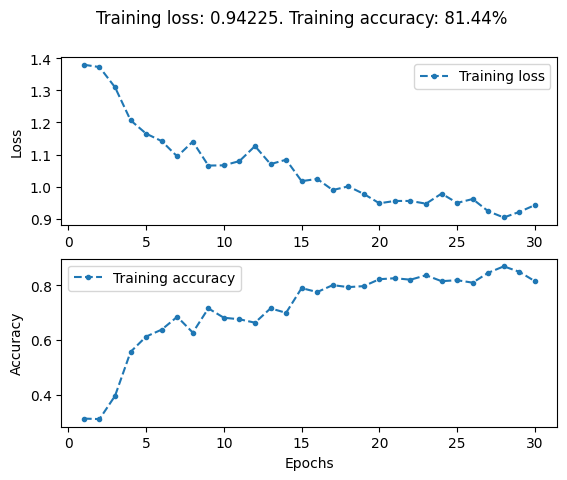

In [64]:
plot_loss_acc(sign_history)

Confusion Matrix

In [65]:
classes = ('AUSSI', 'LS', 'OUI', 'AVOIR')
# Passer les données de test dans le modèle pour obtenir les probabilités
probabilities = sign_model(X_test)

# Obtenir les classes prédites en choisissant l'indice de la classe ayant la probabilité la plus élevée
y_pred = torch.argmax(probabilities, dim=1)

In [66]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.706294
Precision: 0.702408
Recall: 0.709985
F1 score: 0.696195


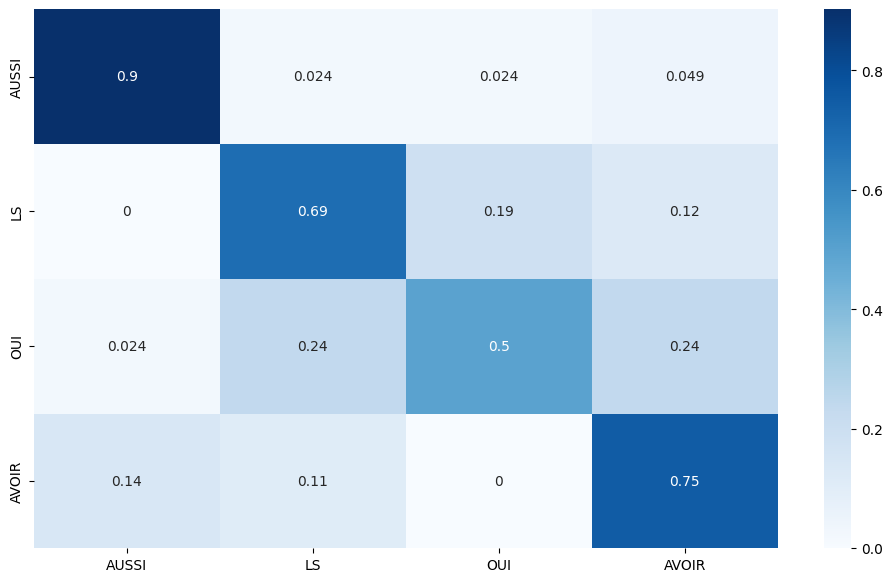

In [67]:
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig('images/MatrixConfusionNN.png')
